In [1]:
import numpy as np
import pandas as pd

from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018

import networkx as nx

import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import glob
import community as community_louvain
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score
import os
import random
import itertools

%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


# Noción de similaridad entre redes

In [2]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
dfLabels["region_side"] = dfLabels["region"] + "_" + dfLabels["side"]

print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side region_side
0        1       Precentral_L  2001  Central    L   Central_L
1        2       Precentral_R  2002  Central    R   Central_R
2        3      Frontal_Sup_L  2101  Frontal    L   Frontal_L
3        4      Frontal_Sup_R  2102  Frontal    R   Frontal_R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L   Frontal_L


In [3]:
filename = '../resources/DataSujetos/N1_suj1.csv'
df = pd.read_csv(filename, header=None)
n = df.shape[0]
df -= np.diag(np.ones(n))
aristas_posibles= (n*n-n)//2
aristas_posibles*0.15 #Busco cantidad tal que densidad sea 0.15

ds = np.arange(150,2200//2,50)
#ds = np.arange(150,2200//2,200)
#ds.max()/aristas_posibles
ds/aristas_posibles

array([0.02248876, 0.02998501, 0.03748126, 0.04497751, 0.05247376,
       0.05997001, 0.06746627, 0.07496252, 0.08245877, 0.08995502,
       0.09745127, 0.10494753, 0.11244378, 0.11994003, 0.12743628,
       0.13493253, 0.14242879, 0.14992504, 0.15742129])

In [4]:
path = r'../resources/DataSujetos' # use your path
sleep_states = ['N1','N2','N3','W']
files_N1 = glob.glob(path + f"/{sleep_states[0]}_suj*.csv")
files_N2 = glob.glob(path + f"/{sleep_states[1]}_suj*.csv")
files_N3 = glob.glob(path + f"/{sleep_states[2]}_suj*.csv")
files_W = glob.glob(path + f"/{sleep_states[3]}_suj*.csv")
files_W

['../resources/DataSujetos\\W_suj1.csv',
 '../resources/DataSujetos\\W_suj10.csv',
 '../resources/DataSujetos\\W_suj11.csv',
 '../resources/DataSujetos\\W_suj12.csv',
 '../resources/DataSujetos\\W_suj13.csv',
 '../resources/DataSujetos\\W_suj14.csv',
 '../resources/DataSujetos\\W_suj15.csv',
 '../resources/DataSujetos\\W_suj16.csv',
 '../resources/DataSujetos\\W_suj17.csv',
 '../resources/DataSujetos\\W_suj18.csv',
 '../resources/DataSujetos\\W_suj2.csv',
 '../resources/DataSujetos\\W_suj3.csv',
 '../resources/DataSujetos\\W_suj4.csv',
 '../resources/DataSujetos\\W_suj5.csv',
 '../resources/DataSujetos\\W_suj6.csv',
 '../resources/DataSujetos\\W_suj7.csv',
 '../resources/DataSujetos\\W_suj8.csv',
 '../resources/DataSujetos\\W_suj9.csv']

In [5]:
def get_modulos(file,edges_density):
    df = pd.read_csv(file, header=None, index_col=None,)
    n = df.shape[0]
    df -= np.diag(np.ones(n))

    sort_corrs = sorted(df.values.flatten(),reverse=True)
    threshold = sort_corrs[edges_density]
    thresh_cmat = (df.values >= threshold) * 1.0
    G = nx.from_numpy_matrix(thresh_cmat)

    label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
    G = nx.relabel_nodes(G, lambda x: label_data['number'].tolist()[x])

    modulos = community_louvain.best_partition(G)
    #print({"umbral":round(threshold,2), "clusters": len(set(modulos.values()))})
    values_obs = [v for n,v in modulos.items()]
    return(values_obs)

In [6]:
files = glob.glob(path + f"/*_suj*.csv")

modulos_by_density_dict = {}
for edges_density in ds:
    print(edges_density)
    modulos_dict = {}
    for file in files:
        modulos_dict[file] = get_modulos(file,edges_density)
        #break
    modulos_by_density_dict[edges_density] = modulos_dict.copy()
    #break

df_modulos = pd.DataFrame(modulos_by_density_dict)
df_modulos

150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050


,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050
../resources/DataSujetos\N1_suj1.csv,"[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 2, 8, 2, 8, ...","[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 2, 1, 2, 1, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 4, 1, 5, 1, 5, 1, ...","[0, 0, 1, 1, 1, 2, 1, 2, 3, 2, 4, 2, 4, 2, 4, ...","[0, 0, 1, 1, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, ...","[0, 0, 1, 1, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 2, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, ...","[0, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
../resources/DataSujetos\N1_suj10.csv,"[0, 0, 1, 1, 2, 2, 1, 1, 3, 4, 5, 1, 5, 1, 5, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 4, 1, 4, 1, 4, ...","[0, 0, 1, 0, 1, 1, 1, 1, 2, 3, 4, 1, 4, 1, 4, ...","[0, 0, 1, 0, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, ...","[0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, ...","[0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, ...","[0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
../resources/DataSujetos\N1_suj11.csv,"[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 8, 9, 10, 11...","[0, 0, 1, 2, 3, 4, 1, 2, 5, 6, 7, 8, 1, 9, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 6, 7, 1, 8, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 6, 7, 1, 8, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 1, 4, 5, 6, 1, 1, 1, ...","[0, 0, 1, 1, 2, 3, 4, 1, 4, 5, 6, 7, 4, 4, 4, ...","[0, 0, 1, 1, 2, 3, 1, 1, 1, 4, 5, 6, 1, 1, 1, ...","[0, 0, 1, 2, 3, 4, 2, 2, 2, 5, 6, 7, 2, 2, 2, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 5, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 5, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 5, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 1, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, ..."
../resources/DataSujetos\N1_suj12.csv,"[0, 1, 2, 2, 3, 4, 2, 2, 5, 6, 2, 2, 2, 2, 7, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 1, 1, 1, 1, 6, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 6, 2, 2, 2, 2, 7, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 1, 1, 1, 1, 6, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 5, 1, 1, 1, 1, 6, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 0, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, ...","[0, 0, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, ...","[0, 1, 2, 2, 3, 4, 2, 2, 5, 2, 2, 2, 2, 2, 2, ...","[0, 1, 0, 0, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 2, 3, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, ...","[0, 1, 0, 0, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 

In [7]:
def measure_rand_score_group(df_modulos, group='N1_', density=150):
    rand_list = []
    dict_modulos = df_modulos[density].filter(like=group, axis=0)
    r = itertools.combinations(dict_modulos.to_dict().keys(), 2)
    for M1,M2 in r:
        #print(M1,M2)
        #print(dict_modulos[M1])
        #print(dict_modulos[M2])
        rand_score = adjusted_rand_score(dict_modulos[M1], dict_modulos[M2])
        #print(rand_score)
        rand_list.append(rand_score)
        #break
    return(rand_list)

In [8]:
rand_by_density_dict = {}
for edges_density in ds:
    rand_dict = {}
    rand = {}
    for state in sleep_states:
        rand[state] = measure_rand_score_group(df_modulos, group=state+'_', density=edges_density)
        rand_dict[state+"_mean"] = np.mean(rand[state])
        rand_dict[state+"_std"] = np.std(rand[state])
    rand_by_density_dict[edges_density] = rand_dict.copy()
rand_by_density = pd.DataFrame(rand_by_density_dict).T
rand_by_density['density']=rand_by_density.index/aristas_posibles
rand_by_density

,N1_mean,N1_std,N2_mean,N2_std,N3_mean,N3_std,W_mean,W_std,density
150,0.403251,0.118895,0.478293,0.098532,0.402653,0.121552,0.336041,0.107456,0.022489
200,0.376615,0.104355,0.483000,0.101409,0.378689,0.107415,0.368286,0.119947,0.029985
250,0.374058,0.084616,0.490786,0.094597,0.339192,0.099723,0.345874,0.121772,0.037481
300,0.375729,0.101471,0.473496,0.090903,0.351817,0.106139,0.347909,0.146029,0.044978
350,0.369187,0.106628,0.442354,0.105022,0.316420,0.103832,0.319549,0.117349,0.052474
400,0.369547,0.105890,0.442098,0.089068,0.322443,0.124957,0.307450,0.104111,0.059970
450,0.388312,0.108629,0.429739,0.096536,0.328794,0.120642,0.323574,0.110848,0.067466
500,0.366244,0.109230,0.425848,0.100597,0.323015,0.123254,0.308491,0.113814,0.074963
550,0.362119,0.087206,0.420639,0.094589,0.335216,0.124398,0.310781,0.100140,0.082459
600,0.351267,0.098680,0.429969,0.092824,0.334416,0.131409,0.305589,0.107658,0.089955


In [10]:
def measure_rand_score_group_random_W(df_modulos, group='N1_', density=150):
    rand_list = []
    dict_modulos = []
    dict_modulos.append(df_modulos[density].filter(like=group, axis=0))
    dict_modulos.append(df_modulos[density].filter(like='W_', axis=0))
    r = itertools.combinations(dict_modulos[0].to_dict().keys(), 2)
    s = itertools.combinations(dict_modulos[1].to_dict().keys(), 2)

    for M1 in zip(r,s):        
        x = random.randint(0,1)
        #print(M1[0][0],M1[x][1])
        rand_score = adjusted_rand_score(df_modulos.loc[M1[0][0],density], df_modulos.loc[M1[x][1],density])
        #print(rand_score)
        rand_list.append(rand_score)
        #break
    return(rand_list)

In [11]:
measure_rand_score_group_random_W(df_modulos, group='N1_', density=150)

[0.3974377767702215,
 0.4104468574657894,
 0.43562858945928506,
 0.48268058255012114,
 0.260083769791394,
 0.5431833108746479,
 0.5436434075449544,
 0.4489457736441628,
 0.45869458233620597,
 0.2748308410975203,
 0.4580729690449162,
 0.48460482649593095,
 0.5249583804428143,
 0.5897578584346833,
 0.4574489199410433,
 0.542367349764437,
 0.49030834241005483,
 0.3833576062491725,
 0.3178272926001092,
 0.36416437652010786,
 0.2640504578303909,
 0.3923357700374517,
 0.40300876422515847,
 0.29092510094253143,
 0.3933754209127651,
 0.1686627596245875,
 0.27875994708883617,
 0.3816700886712845,
 0.4576889747004543,
 0.44095180916261956,
 0.34023388630016244,
 0.3452787514161496,
 0.35180944678892734,
 0.3404828812295693,
 0.3551952837140752,
 0.2438805418394022,
 0.4041064835805428,
 0.45466966725606817,
 0.325941144480029,
 0.6266233766233766,
 0.13364365774483986,
 0.27527700831024926,
 0.3330876934414149,
 0.3149664929262844,
 0.4708941788357671,
 0.3732120810623626,
 0.38821443186468424,


In [12]:
random.seed(938413)

Np = 1000

rand_df_list = []
rand_df_avg = rand_by_density.copy()
for kk in range(Np):
    print(kk)
    rand_by_density_dict = {}
    for edges_density in ds:
        rand_dict = {}
        rand = {}
        for state in sleep_states:
            rand[state] = measure_rand_score_group_random_W(df_modulos, group=state+'_', density=edges_density)
            rand_dict[state+"_mean"] = np.mean(rand[state])
            rand_dict[state+"_std"] = np.std(rand[state])
        rand_by_density_dict[edges_density] = rand_dict.copy()
    rand_df_ = pd.DataFrame(rand_by_density_dict).T
    rand_df_['density']=rand_df_.index/aristas_posibles
    rand_df_list.append(rand_df_)
    rand_df_avg = rand_df_avg+rand_df_
rand_by_density_random = rand_df_avg/(Np+1)

rand_by_density_random

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,N1_mean,N1_std,N2_mean,N2_std,N3_mean,N3_std,W_mean,W_std,density
150,0.380892,0.117232,0.423258,0.107596,0.374529,0.112047,0.336041,0.107456,0.022489
200,0.371035,0.103596,0.431405,0.110278,0.366814,0.101969,0.368286,0.119947,0.029985
250,0.366079,0.090965,0.432915,0.112934,0.343691,0.102511,0.345874,0.121772,0.037481
300,0.369574,0.110131,0.415624,0.111600,0.351162,0.106330,0.347909,0.146029,0.044978
350,0.363500,0.105711,0.395435,0.110070,0.320516,0.104461,0.319549,0.117349,0.052474
400,0.360078,0.106097,0.390452,0.103662,0.321031,0.115943,0.307450,0.104111,0.059970
450,0.377669,0.108624,0.393102,0.102573,0.333031,0.111620,0.323574,0.110848,0.067466
500,0.355375,0.107930,0.386674,0.103389,0.325750,0.115857,0.308491,0.113814,0.074963
550,0.353015,0.091963,0.383771,0.100206,0.333569,0.115786,0.310781,0.100140,0.082459
600,0.343822,0.100535,0.389282,0.102463,0.331945,0.120640,0.305589,0.107658,0.089955


In [51]:
len(rand_df_list)

1000

In [52]:
resta = (rand_by_density)*0.0
for rand_df_ in rand_df_list:
    resta = resta+(rand_by_density<rand_df_)*1.0
pvalues = resta[['N1_mean','N2_mean','N3_mean']]/len(rand_df_list)
pvalues['density']=pvalues.index/aristas_posibles

significancia = pvalues[pvalues<0.05]*0.0
significancia['density']=significancia.index/aristas_posibles

pvalues

,N1_mean,N2_mean,N3_mean,density
150,0.000,0.0,0.000,0.022489
200,0.081,0.0,0.002,0.029985
250,0.028,0.0,0.846,0.037481
300,0.105,0.0,0.434,0.044978
350,0.102,0.0,0.824,0.052474
400,0.042,0.0,0.399,0.059970
450,0.018,0.0,0.844,0.067466
500,0.008,0.0,0.722,0.074963
550,0.012,0.0,0.354,0.082459
600,0.045,0.0,0.318,0.089955


In [20]:
rand_df_list[0][['N1_mean','N2_mean','N3_mean']]

,N1_mean,N2_mean,N3_mean
150,0.378938,0.419597,0.371865
200,0.377134,0.427725,0.359199
250,0.365953,0.429550,0.356006
300,0.381835,0.407538,0.350961
350,0.363426,0.395641,0.325432
400,0.352291,0.402984,0.320203
450,0.383057,0.389762,0.337389
500,0.355503,0.378265,0.324058
550,0.351320,0.379306,0.333703
600,0.341772,0.395091,0.328546


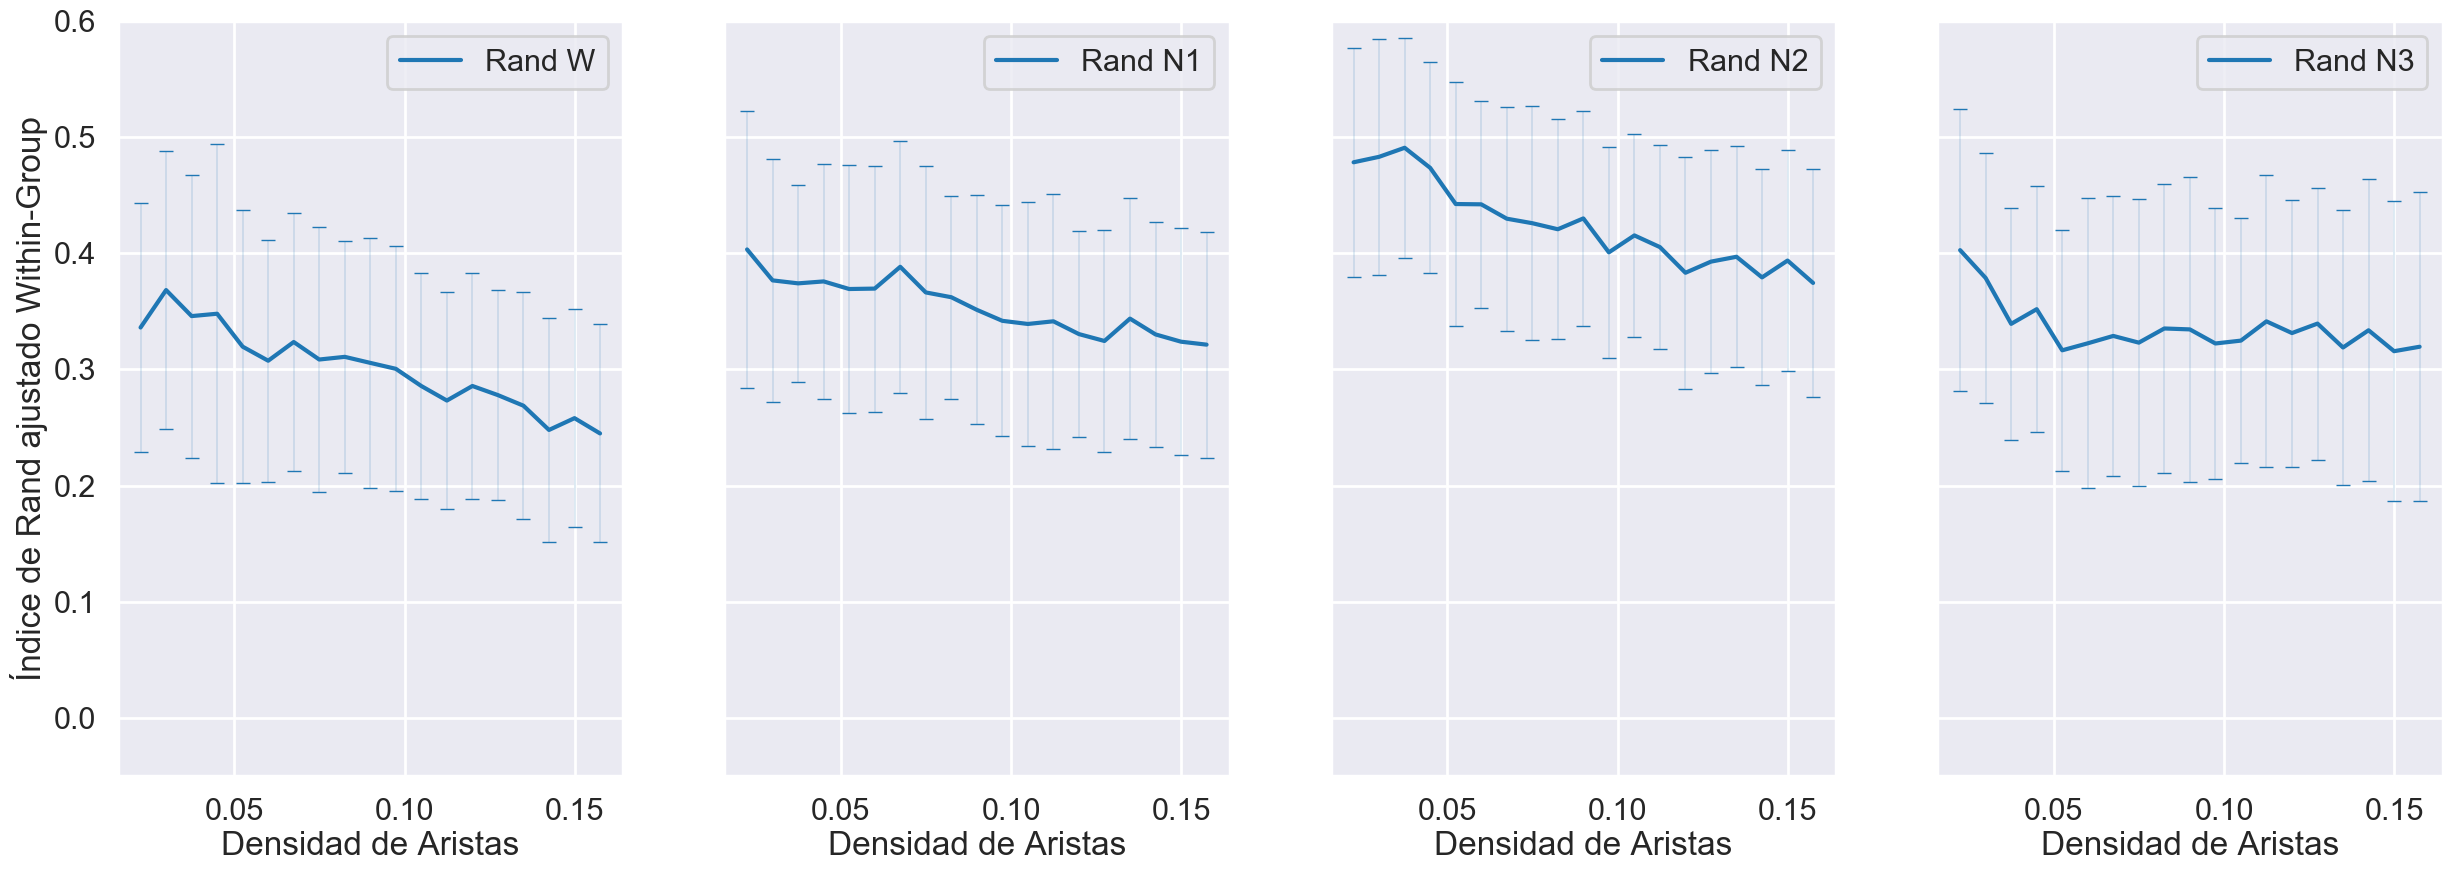

In [58]:
plt.rcParams['errorbar.capsize']=5

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)

rand_by_density.plot("density","W_mean",yerr="W_std",ax=ax1,style='^-',label='Rand W',elinewidth=.2,)
rand_by_density.plot("density","N1_mean",yerr="N1_std",ax=ax2,style='^-',label='Rand N1',elinewidth=.2,)
rand_by_density.plot("density","N2_mean",yerr="N2_std",ax=ax3,style='^-',label='Rand N2',elinewidth=.2,)
rand_by_density.plot("density","N3_mean",yerr="N3_std",ax=ax4,style='^-',label='Rand N3',elinewidth=.2,)

ax1.set_ylim([-.05,0.6])
ax1.set_ylabel('Índice de Rand ajustado Within-Group')
ax1.set_xlabel('Densidad de Aristas')
ax2.set_xlabel('Densidad de Aristas')
ax3.set_xlabel('Densidad de Aristas')
ax4.set_xlabel('Densidad de Aristas')

plt.savefig(f'../graficos/4_rand_ajustado.png') #

In [54]:
df_concat = pd.concat(rand_df_list)[['N1_mean','N2_mean','N3_mean']]
df_concat[df_concat.index==1]

by_row_index = df_concat.groupby(df_concat.index)
df_means = by_row_index.mean()
df_std = by_row_index.std()



In [55]:
df_perm_means = pd.concat([df_means.add_suffix('_means'), df_std.add_suffix('_std')],axis=1)
df_perm_means['density']=df_perm_means.index/aristas_posibles

df_perm_means

,N1_mean_means,N2_mean_means,N3_mean_means,N1_mean_std,N2_mean_std,N3_mean_std,density
150,0.380870,0.423203,0.374501,0.004405,0.006487,0.004750,0.022489
200,0.371030,0.431353,0.366802,0.003949,0.006145,0.004153,0.029985
250,0.366071,0.432857,0.343696,0.004229,0.006661,0.004488,0.037481
300,0.369567,0.415567,0.351162,0.004794,0.006841,0.004356,0.044978
350,0.363494,0.395388,0.320520,0.004363,0.006189,0.004482,0.052474
400,0.360069,0.390400,0.321029,0.005236,0.006240,0.004885,0.059970
450,0.377659,0.393065,0.333035,0.005076,0.005528,0.004433,0.067466
500,0.355364,0.386635,0.325753,0.004750,0.006046,0.004499,0.074963
550,0.353006,0.383735,0.333567,0.003852,0.004878,0.004728,0.082459
600,0.343814,0.389241,0.331942,0.004539,0.005398,0.005122,0.089955


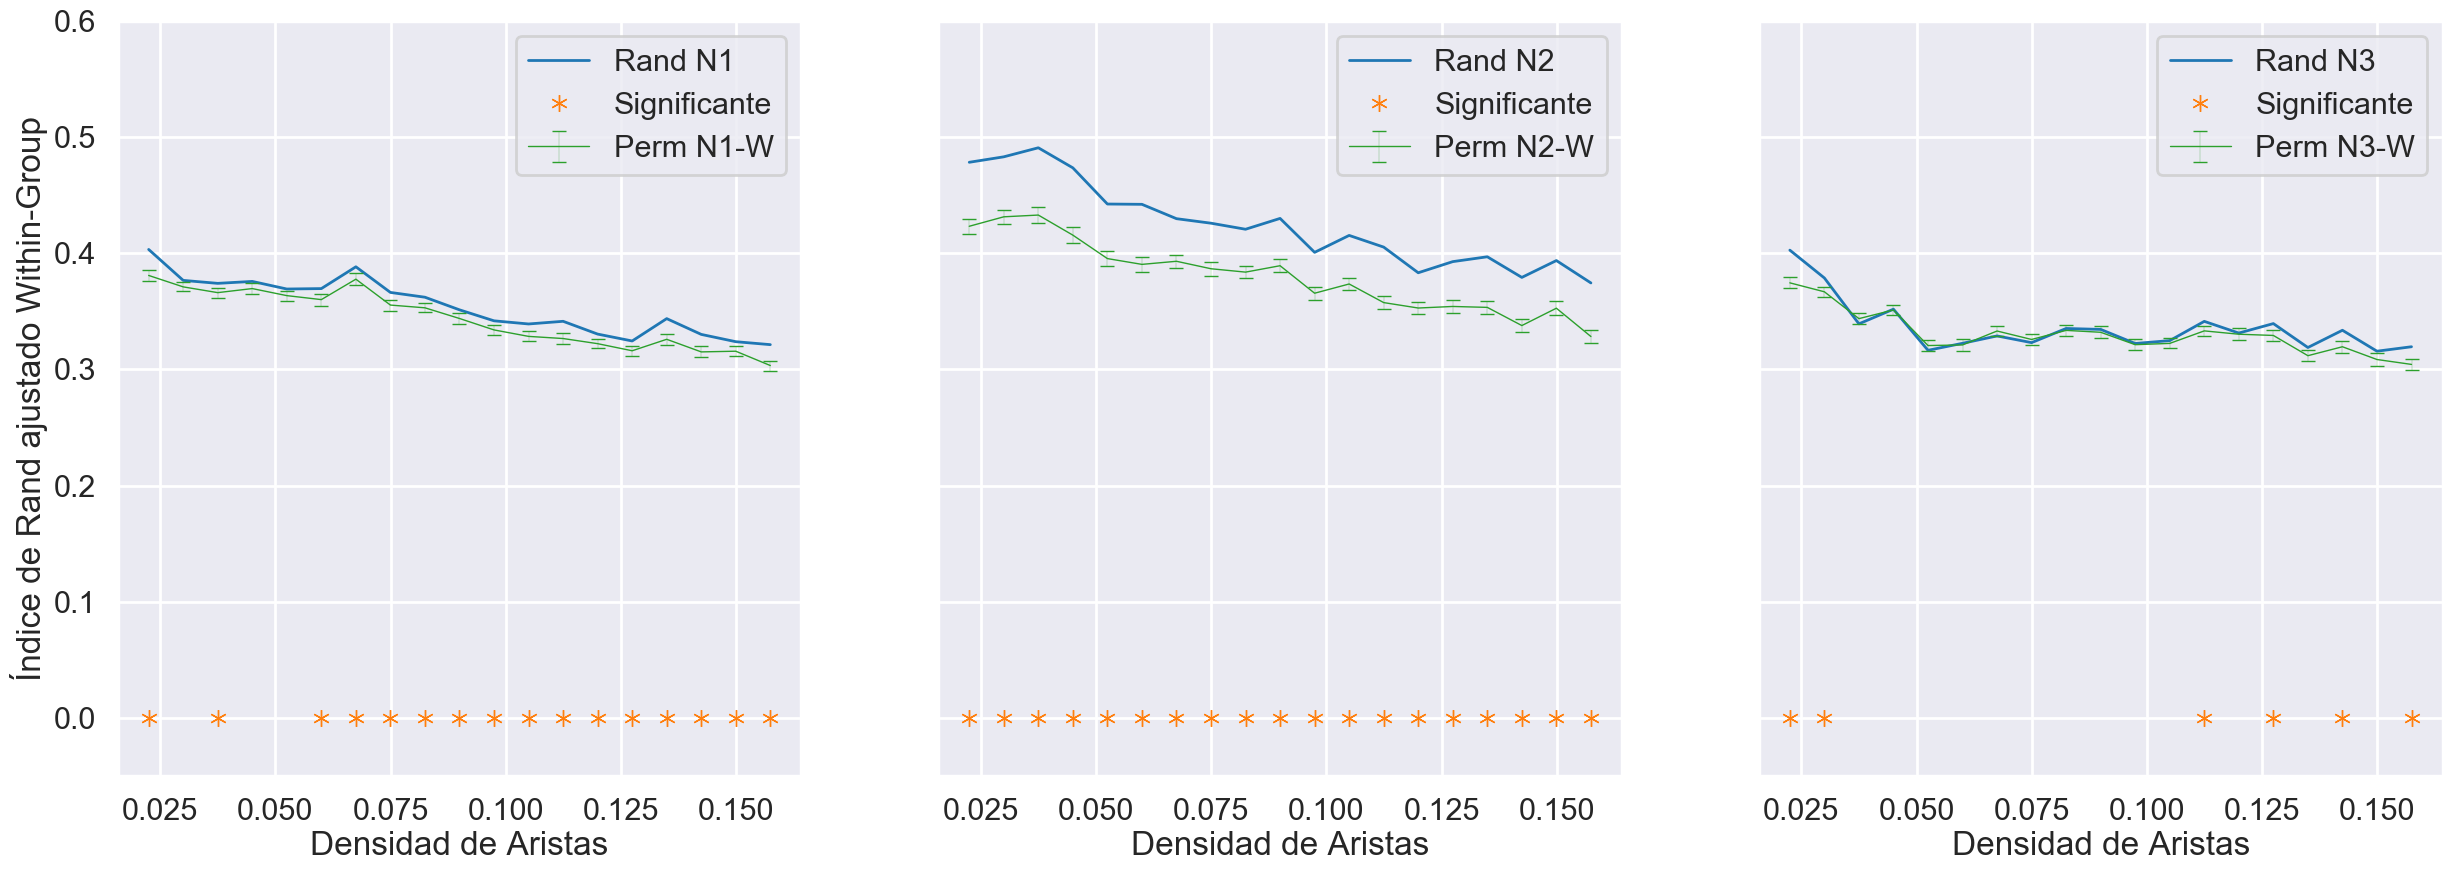

In [59]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

rand_by_density.plot("density","N1_mean",ax=ax1,style='-',label='Rand N1',linewidth=2)
rand_by_density.plot("density","N2_mean",ax=ax2,style='-',label='Rand N2',linewidth=2)
rand_by_density.plot("density","N3_mean",ax=ax3,style='-',label='Rand N3',linewidth=2)

significancia.plot("density","N1_mean" , linestyle='',marker=(6, 2, 0),ax=ax1,label='Significante')
significancia.plot("density","N2_mean" , linestyle='',marker=(6, 2, 0),ax=ax2,label='Significante')
significancia.plot("density","N3_mean" , linestyle='',marker=(6, 2, 0),ax=ax3,label='Significante')

df_perm_means.plot("density","N1_mean_means",yerr="N1_mean_std",ax=ax1,style='..',label='Perm N1-W',elinewidth=.2,linewidth=1)
df_perm_means.plot("density","N2_mean_means",yerr="N2_mean_std",ax=ax2,style='..',label='Perm N2-W',elinewidth=.2,linewidth=1)
df_perm_means.plot("density","N3_mean_means",yerr="N3_mean_std",ax=ax3,style='..',label='Perm N3-W',elinewidth=.2,linewidth=1)

ax1.set_ylim([-.05,0.6])

ax1.set_ylabel('Índice de Rand ajustado Within-Group')
ax1.set_xlabel('Densidad de Aristas')
ax2.set_xlabel('Densidad de Aristas')
ax3.set_xlabel('Densidad de Aristas')

plt.savefig(f'../graficos/4_significancia_pvalue.png') #

Si es significante, esto implica que hay un patrón en el agrupamiento que se hace en el estado Nx, y que es significativamente distinto al agrupamiento que se hace en W, y dicha diferencia no es causada por un factor aleatorio.